In [663]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

## Data Generation

In [595]:
# Set the number of students
num_students = 5000
# Create empty lists to store the data
student_id = []
age = []
gender = []
ethnicity = []
test_scores_math = []
test_scores_english = []
parental_education = []
parental_income = []
intervention_group = []
attendance_rate = []
behavioral_problems = []
extracurricular_activities = []
graduation_status = []
college_enrollment = []
employment_status = []

In [596]:
# Introduce bias for African American and Hispanic students
for _ in range(num_students):
    student_id.append(len(student_id) + 1)
    age.append(np.random.randint(6, 18))
    gender.append(random.choice(['Male', 'Female']))
    ethnicity_choice = np.random.choice(['Caucasian', 'African American', 'Hispanic', 'Asian', 'Other'])
    ethnicity.append(ethnicity_choice)
    test_scores_math.append(np.random.normal(70, 10))
    test_scores_english.append(np.random.normal(75, 8))
    parental_education.append(random.choice(['High School', 'Bachelor', 'Master', 'PhD']))
    parental_income.append(np.random.normal(50000, 10000))
    intervention_group.append(random.choice([0, 1, 1, 1]))
    attendance_rate.append(np.random.uniform(0.8, 1.0))
    behavioral_problems.append(np.random.randint(0, 11))
    extracurricular_activities.append(np.random.randint(0, 6))
    # Introduce bias based on ethnicity
    if ethnicity_choice in ['African American', 'Hispanic']:

    # African American and Hispanic students have higher chances of not graduating, not enrolling in college, and being unemployed
        graduation_status_choice = random.choices(['Did not graduate', 'Graduated'], weights=[0.7, 0.3])[0]
        college_enrollment_choice = random.choices(['Not enrolled', 'Enrolled'], weights=[0.7, 0.3])[0]
        employment_status_choice = random.choices(['Unemployed', 'Employed'], weights=[0.7, 0.3])[0]
    else:
    # For other ethnicities, use default values
        graduation_status_choice = 'Graduated'
        college_enrollment_choice = 'Enrolled'
        employment_status_choice = 'Employed'
    graduation_status.append(graduation_status_choice)
    college_enrollment.append(college_enrollment_choice)
    employment_status.append(employment_status_choice)

In [597]:
# Create a DataFrame
data = {
'Student_ID': student_id,
'Age': age,
'Gender': gender,
'Ethnicity': ethnicity,
'Test_Scores_Math': test_scores_math,
'Test_Scores_English': test_scores_english,
'Parental_Education': parental_education,
'Parental_Income': parental_income,
'Intervention_Group': intervention_group,
'Attendance_Rate': attendance_rate,
'Behavioral_Problems': behavioral_problems,
'Extracurricular_Activities': extracurricular_activities,
'Graduation_Status': graduation_status,
'College_Enrollment': college_enrollment,
'Employment_Status': employment_status
}

In [598]:
df = pd.DataFrame(data)

In [599]:
# Display the first few rows of the dataset
df.head()

,Student_ID,Age,Gender,Ethnicity,Test_Scores_Math,Test_Scores_English,Parental_Education,Parental_Income,Intervention_Group,Attendance_Rate,Behavioral_Problems,Extracurricular_Activities,Graduation_Status,College_Enrollment,Employment_Status
0,1,6,Male,Asian,55.708290,92.926401,High School,44288.140263,1,0.862059,6,1,Graduated,Enrolled,Employed
1,2,11,Female,Other,61.754956,70.077410,PhD,50877.179035,0,0.993270,5,2,Graduated,Enrolled,Employed
2,3,16,Male,Asian,81.410847,81.994085,High School,40782.700246,1,0.891378,10,3,Graduated,Enrolled,Employed
3,4,13,Male,Other,73.588088,80.850643,Master,55886.704738,1,0.904479,6,0,Graduated,Enrolled,Employed
4,5,16,Female,Caucasian,53.771371,74.361497,Bachelor,38479.270867,1,0.885820,9,4,Graduated,Enrolled,Employed


In [600]:
# Save the dataset to a CSV file
df.to_csv('biased_outcomes_simulated_education_data.csv', index=False)

## Data Exploration

In [601]:
df = pd.read_csv('biased_outcomes_simulated_education_data.csv')

In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   int64  
 1   Age                         5000 non-null   int64  
 2   Gender                      5000 non-null   object 
 3   Ethnicity                   5000 non-null   object 
 4   Test_Scores_Math            5000 non-null   float64
 5   Test_Scores_English         5000 non-null   float64
 6   Parental_Education          5000 non-null   object 
 7   Parental_Income             5000 non-null   float64
 8   Intervention_Group          5000 non-null   int64  
 9   Attendance_Rate             5000 non-null   float64
 10  Behavioral_Problems         5000 non-null   int64  
 11  Extracurricular_Activities  5000 non-null   int64  
 12  Graduation_Status           5000 non-null   object 
 13  College_Enrollment          5000 

In [603]:
#encoding categorical variables
df['Parental_Education_num'] = df['Parental_Education'].apply(lambda x: 0 if x == 'High School' else 1 if x == 'Bachelor' else 2 if x == 'Master' else 3)
df['Graduation_Status_num'] = df['Graduation_Status'].apply(lambda x: 1 if x == 'Graduated' else 0)
df['College_Enrollment_num'] = df['College_Enrollment'].apply(lambda x: 1 if x == 'Enrolled' else 0)
df['Employment_Status_num'] = df['Employment_Status'].apply(lambda x: 1 if x == 'Employed' else 0)
df['Gender_num'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)


df['Ethnicity_Other'] = df['Ethnicity'].apply(lambda x: 1 if x == 'Other' else 0)
df['Ethnicity_Asian'] = df['Ethnicity'].apply(lambda x: 1 if x == 'Asian' else 0)
df['Ethnicity_Caucasian'] = df['Ethnicity'].apply(lambda x: 1 if x == 'Caucasian' else 0)
df['Ethnicity_Hispanic'] = df['Ethnicity'].apply(lambda x: 1 if x == 'Hispanic' else 0)
df['Ethnicity_AfricanAmerican'] = df['Ethnicity'].apply(lambda x: 1 if x == 'African American' else 0)

In [604]:
# Summary statistics  
df.describe().round(2)

,Student_ID,Age,Test_Scores_Math,Test_Scores_English,Parental_Income,Intervention_Group,Attendance_Rate,Behavioral_Problems,Extracurricular_Activities,Parental_Education_num,Graduation_Status_num,College_Enrollment_num,Employment_Status_num,Gender_num,Ethnicity_Other,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_AfricanAmerican
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00,5000.0,5000.00,5000.0,5000.0
mean,2500.50,11.53,69.86,75.04,50091.53,0.75,0.90,4.95,2.50,1.49,0.72,0.72,0.72,0.5,0.19,0.2,0.21,0.2,0.2
std,1443.52,3.44,9.94,7.88,9948.41,0.43,0.06,3.18,1.72,1.12,0.45,0.45,0.45,0.5,0.39,0.4,0.41,0.4,0.4
min,1.00,6.00,37.27,45.16,13072.39,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0
25%,1250.75,9.00,63.06,69.74,43473.36,0.00,0.85,2.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0
50%,2500.50,11.00,69.77,75.04,50136.87,1.00,0.90,5.00,3.00,1.00,1.00,1.00,1.00,0.0,0.00,0.0,0.00,0.0,0.0
75%,3750.25,15.00,76.68,80.51,56875.26,1.00,0.95,8.00,4.00,2.00,1.00,1.00,1.00,1.0,0.00,0.0,0.00,0.0,0.0
max,5000.00,17.00,105.87,104.55,88105.98,1.00,1.00,10.00,5.00,3.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.0


In [605]:
# Graduation, college, employment rates by ethnicity
grad_rate = df.groupby(['Ethnicity'])['Graduation_Status'].value_counts(normalize=True)
coll_rate = df.groupby(['Ethnicity'])['College_Enrollment'].value_counts(normalize=True)
emp_rate = df.groupby(['Ethnicity'])['Employment_Status'].value_counts(normalize=True)

In [606]:
grad_rate

Ethnicity         Graduation_Status
African American  Did not graduate     0.707269
                  Graduated            0.292731
Asian             Graduated            1.000000
Caucasian         Graduated            1.000000
Hispanic          Did not graduate     0.690669
                  Graduated            0.309331
Other             Graduated            1.000000
Name: Graduation_Status, dtype: float64

In [607]:
coll_rate

Ethnicity         College_Enrollment
African American  Not enrolled          0.701375
                  Enrolled              0.298625
Asian             Enrolled              1.000000
Caucasian         Enrolled              1.000000
Hispanic          Not enrolled          0.707911
                  Enrolled              0.292089
Other             Enrolled              1.000000
Name: College_Enrollment, dtype: float64

In [608]:
emp_rate

Ethnicity         Employment_Status
African American  Unemployed           0.695481
                  Employed             0.304519
Asian             Employed             1.000000
Caucasian         Employed             1.000000
Hispanic          Unemployed           0.705882
                  Employed             0.294118
Other             Employed             1.000000
Name: Employment_Status, dtype: float64

In [ ]:
# T-tests

group1 = df[df['Ethnicity']=='African American']['Test_Scores_Math']  
group2 = df[df['Ethnicity']=='Hispanic']['Test_Scores_Math']

tstat, pval = ttest_ind(group1, group2)

print('\nT-test p-value:')
print(pval)


T-test p-value:
0.4240872491673475


In [ ]:
group3 = df[df['Ethnicity']=='Caucasian']['Test_Scores_Math'] 
group4 = df[df['Ethnicity']=='African American']['Test_Scores_Math']

tstat, pval = ttest_ind(group3, group4)

print('\nT-test p-value:')
print(pval)


T-test p-value:
0.5202094846462803


In [687]:
group5 = df[df['Gender']=='Male']['Extracurricular_Activities'] 
group6 = df[df['Gender']=='Female']['Extracurricular_Activities']

tstat, pval = ttest_ind(group5, group6)

print('\nT-test p-value:')
print(pval)


T-test p-value:
0.4597662257112497


In [688]:
group7 = df[df['Gender']=='Male']['Employment_Status_num'] 
group8 = df[df['Gender']=='Female']['Employment_Status_num']

tstat, pval = ttest_ind(group7, group8)

print('\nT-test p-value:')
print(pval)


T-test p-value:
0.9419331715915096


In [690]:
group9 = df[df['Parental_Education']=='PhD']['College_Enrollment_num'] 
group10 = df[df['Parental_Education']=='Bachelor']['College_Enrollment_num']

tstat, pval = ttest_ind(group9, group10)

print('\nT-test p-value:')
print(pval)


T-test p-value:
0.7623391344790914


#### The t-tests compared outcomes and features between different student group to findd out about biases in the simulated dataset. The null hypothesis is that the means are equal between each two ethnic groups. The alternative hypothesis is that the means are unequal. The p-values indicated that there is no statistically significant difference in the means. Since all of the p-values are greater than the typical significance level of 0.05, we fail to reject the null hypothesis. In other words, based on these statistical test, we cannot conclude that there is a significant difference between each of the paired groups of above (1-2,3-4,5-6,7-8,9-10) within the simulated data. 

C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\1554302924.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().round(3), annot=True)


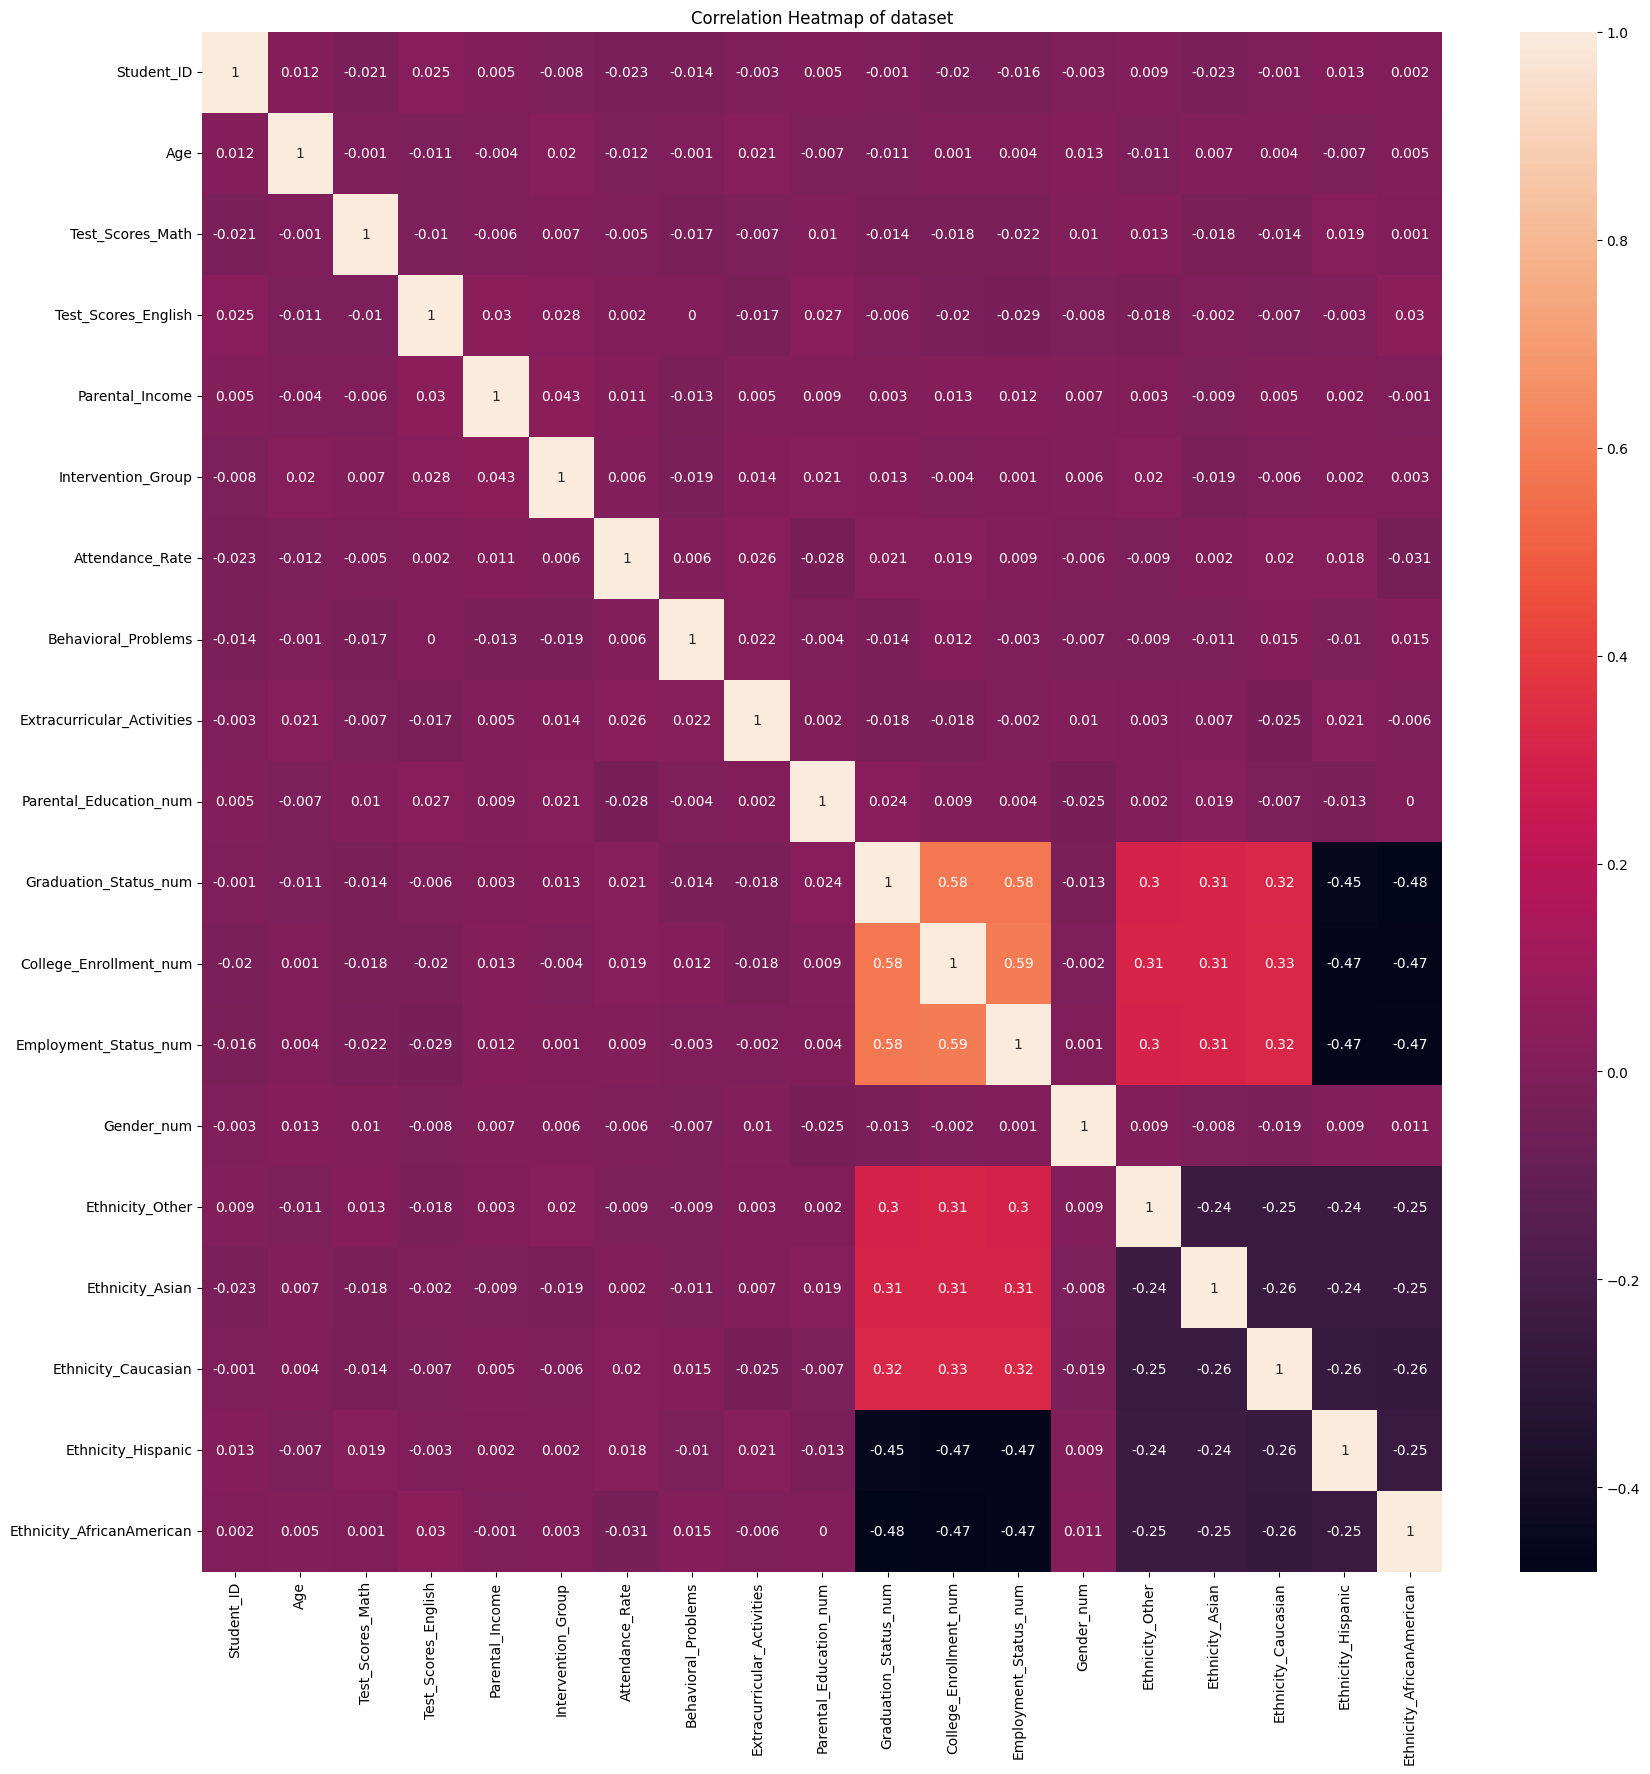

In [609]:
# Creating heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr().round(3), annot=True)
plt.title('Correlation Heatmap of dataset')
plt.show()

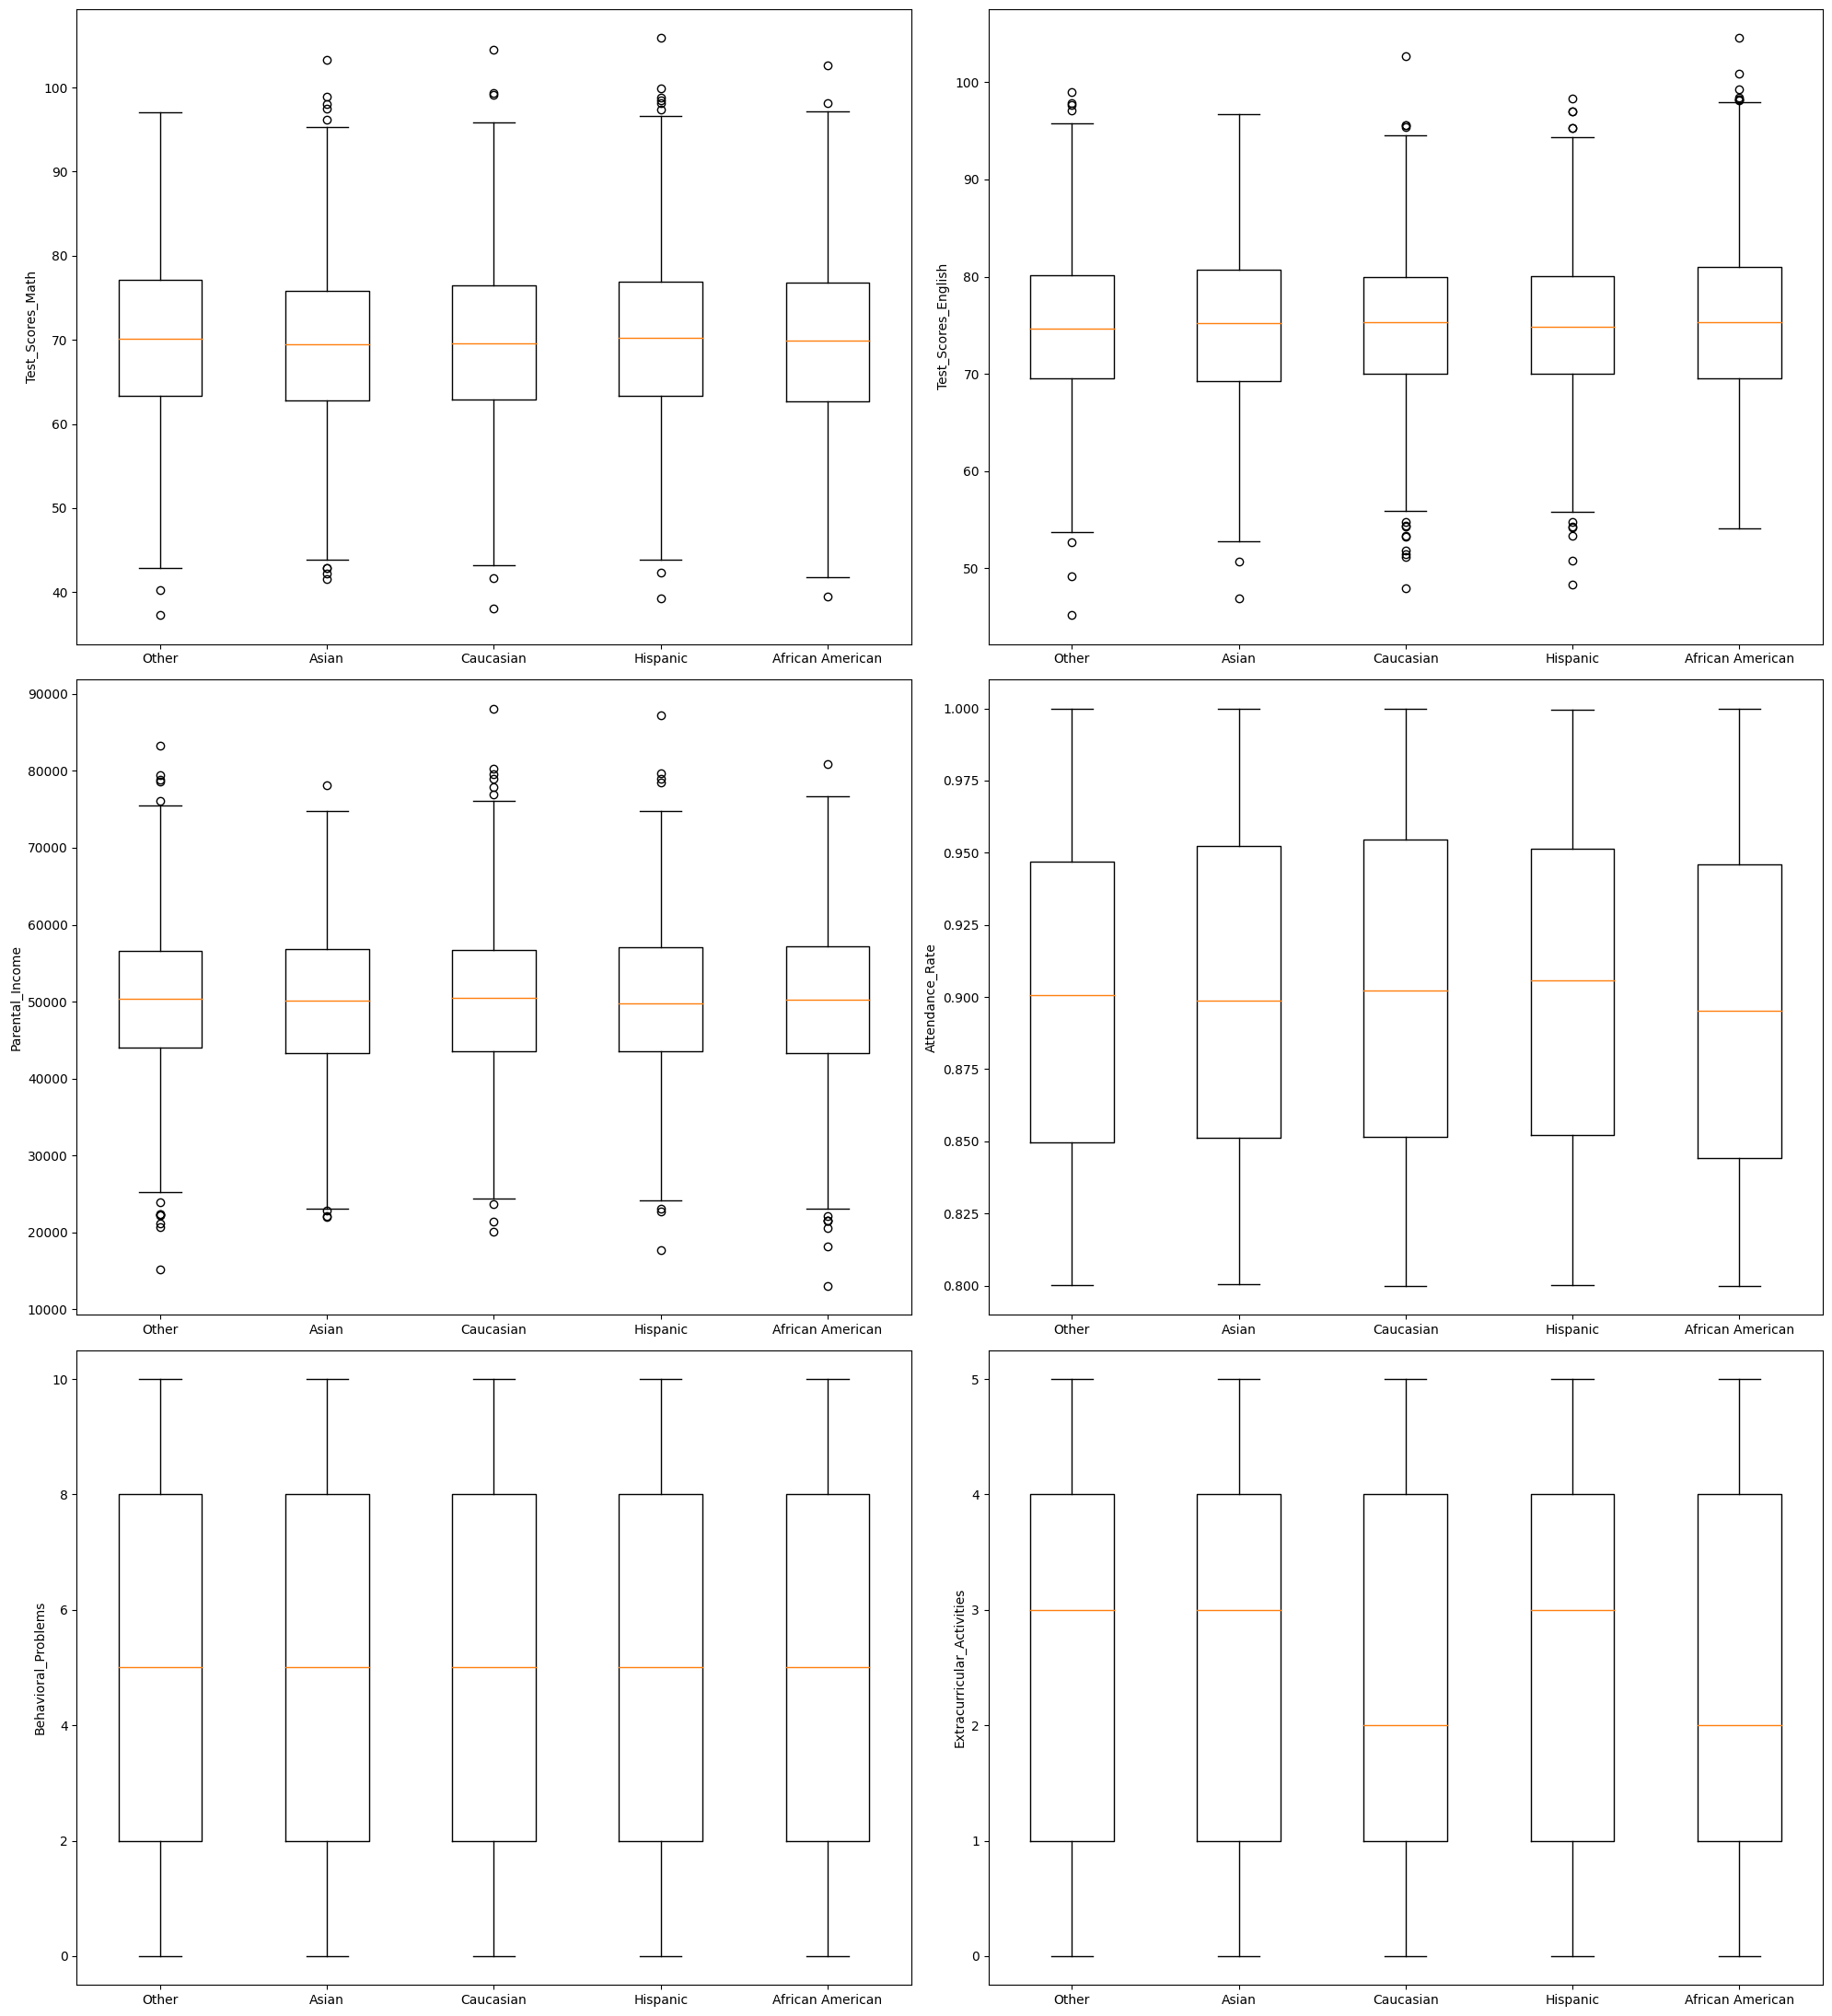

In [610]:
#Box plots of variables in dataset by ethnicity

vars = ['Test_Scores_Math', 'Test_Scores_English', 'Parental_Income', 'Attendance_Rate', 'Behavioral_Problems', 'Extracurricular_Activities']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 22))

for i, ax in enumerate(axs.flatten()):
    ax.boxplot([df[df['Ethnicity_Other']==1][vars[i]],
                 df[df['Ethnicity_Asian']==1][vars[i]],
                 df[df['Ethnicity_Caucasian']==1][vars[i]],
                 df[df['Ethnicity_Hispanic']==1][vars[i]],
                 df[df['Ethnicity_AfricanAmerican']==1][vars[i]]])
    ax.set_xticklabels(['Other', 'Asian', 'Caucasian', 'Hispanic', 'African American'])
    ax.set_ylabel(vars[i])

#fig.suptitle('Box plots of variables in dataset by ethnicity', fontsize=16)
plt.tight_layout()
plt.show()

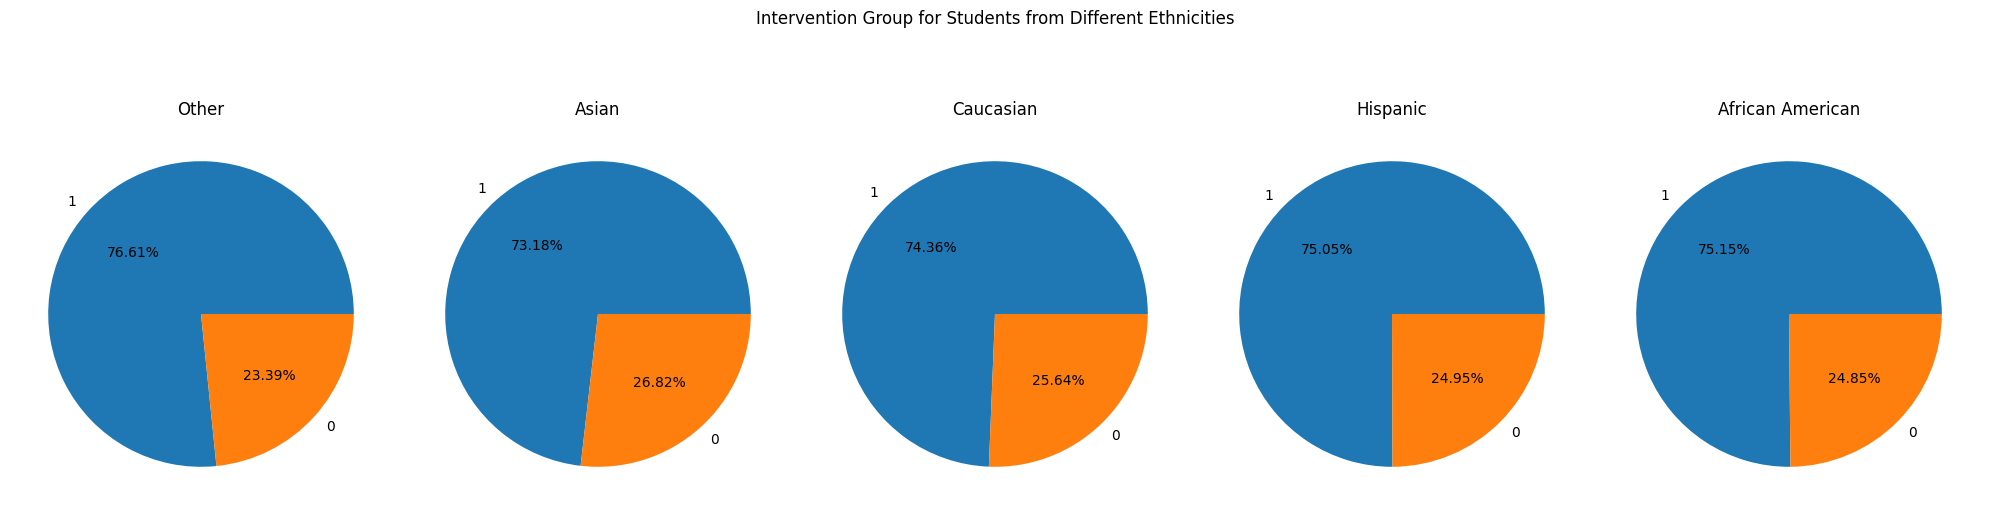

In [611]:
vars = ['Other', 'Asian', 'Caucasian', 'Hispanic', 'African American']

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6)) 

plt.suptitle('Intervention Group for Students from Different Ethnicities')

for i, ax in enumerate(axs.flatten()):
    
    group_counts = df[df['Ethnicity'] == vars[i]]['Intervention_Group'].value_counts()

    ax.pie(group_counts, labels=group_counts.index, autopct='%1.2f%%')
    ax.set_title(vars[i])

plt.tight_layout()
plt.show()

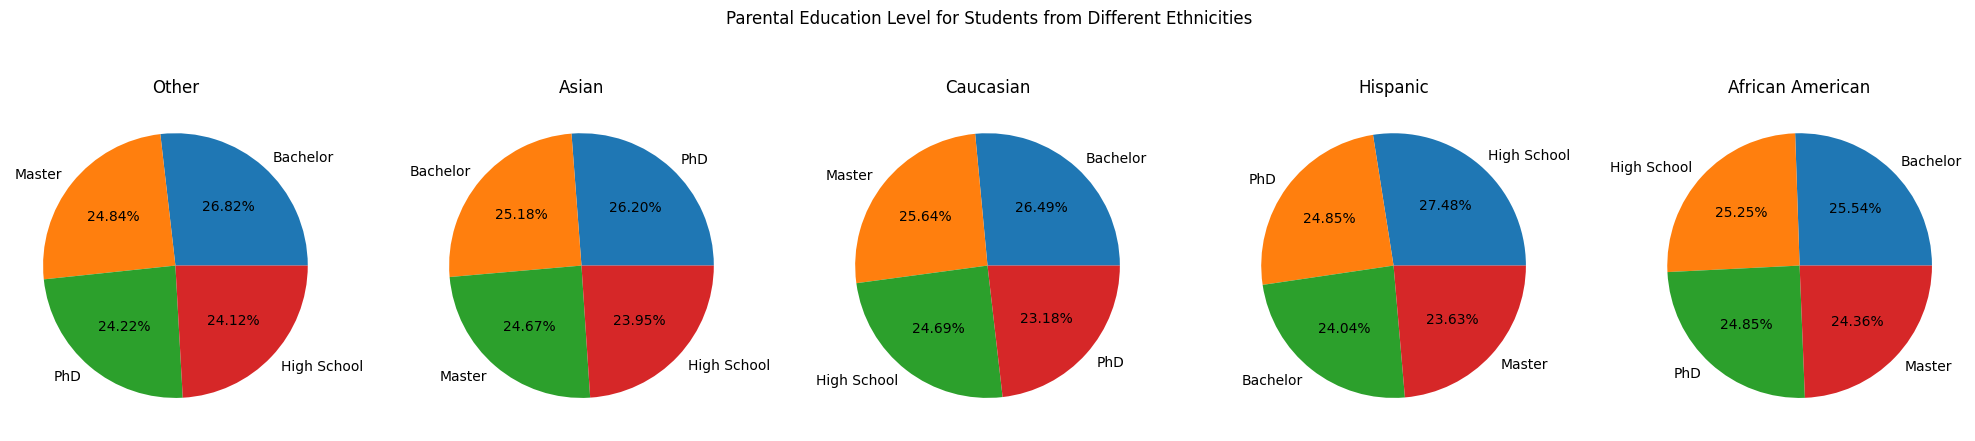

In [612]:
vars = ['Other', 'Asian', 'Caucasian', 'Hispanic', 'African American']

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5)) 

plt.suptitle('Parental Education Level for Students from Different Ethnicities')

for i, ax in enumerate(axs.flatten()):
    
    group_counts = df[df['Ethnicity'] == vars[i]]['Parental_Education'].value_counts()

    ax.pie(group_counts, labels=group_counts.index, autopct='%1.2f%%')
    ax.set_title(vars[i])

plt.tight_layout()
plt.show()

## Hypothesis Formulation

- Hypothesis one:

1. Tutoring interventions will improve graduation rates more for African American students compared to Hispanic students.  

Null hypothesis: The effect of tutoring interventions on graduation rates does not differ between ethnic groups.

Alternative hypothesis: The effect of tutoring interventions on graduation rates is greater for African American students compared to Hispanic students.

- Hypothesis Two:

2. Structured mentorship programs will increase college enrollment rates for Hispanic students compared to Hispanic students not in mentorship programs.

Null hypothesis: Participation in a mentorship program does not affect college enrollment rates for Hispanic students. 

Alternative hypothesis: Participation in a mentorship program increases college enrollment rates for Hispanic students compared to those not in a program.

- Hypothesis Three:

3. Providing financial aid will reduce behavioral incidents for low-income students compared to those not receiving aid.

Null hypothesis: Financial aid does not affect behavior for low-income students.

Alternative hypothesis: Financial aid reduces behavioral incidents for low-income students compared to those not receiving aid.


## Simulation Setup Via Machine Learning Approach

In [631]:
# Model for H1  
# Splitting data into train and test sets
X1 = df[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
       'Intervention_Group', 'Extracurricular_Activities', 
       'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
       'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
       'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican', 
       'College_Enrollment_num', 'Attendance_Rate', 'Behavioral_Problems']]
 
y1 = df[['Graduation_Status']]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=111)

In [632]:
# Model for H2
X2 = df[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
       'Intervention_Group', 'Extracurricular_Activities', 
       'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
       'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
       'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
       'Graduation_Status_num', 'Attendance_Rate', 'Behavioral_Problems']] 

y2 = df[['College_Enrollment']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=111)

In [633]:
# Converting target to categorical
df['Behavioral_Problems_Cat'] = (pd.cut(data['Behavioral_Problems'], bins=[-1, 5, 8, 10], labels=['Low','Medium','High'])).astype('object')

# Model for H3
X3 = df[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
       'Intervention_Group', 'Extracurricular_Activities', 
       'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
       'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
       'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
       'Graduation_Status_num', 'Attendance_Rate', 'College_Enrollment_num']] 

y3 = df[['Behavioral_Problems_Cat']]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=111)

In [634]:
# Training random forest models on student attributes to predict outcomes
model1 = RandomForestClassifier()
model1.fit(X1_train, y1_train)

model2 = RandomForestClassifier()
model2.fit(X2_train, y2_train)

model3 = RandomForestClassifier()
model3.fit(X3_train, y3_train)

C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\766666184.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X1_train, y1_train)


C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\766666184.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2.fit(X2_train, y2_train)
C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\766666184.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3.fit(X3_train, y3_train)


RandomForestClassifier()

In [635]:
# predictions on test set
y1_pred = model1.predict(X1_test)

y2_pred = model2.predict(X2_test)

y3_pred = model3.predict(X3_test)

In [636]:
# Evaluating model accuracy
print("Accuracy of Model 1:", accuracy_score(y1_test, y1_pred))

print("Accuracy of Model 2:", accuracy_score(y2_test, y2_pred))

print("Accuracy  of Model 3:", accuracy_score(y3_test, y3_pred))

Accuracy of Model 1: 0.876
Accuracy of Model 2: 0.887
Accuracy  of Model 3: 0.548


## Intervention Scenarios

In [649]:
# Scenario 1
# Designing Function to simulate interventions by modifying data

def simulate_intervention1(data):
  
  # Setting tutoring intervention for African American and Caucasian students
  data.loc[data['Ethnicity'] == 'African American','Intervention_Group'] = 1  
  data.loc[data['Ethnicity'] == 'Hispanic','Intervention_Group'] = 1
   
  
  return data

# copy for scenario 1 
df_tutoring = df.copy()

# Generating predictions on modified data to assess effects
modified_data = simulate_intervention1(df_tutoring)
modified_X = modified_data[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
                            'Intervention_Group', 'Extracurricular_Activities', 
                            'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
                            'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
                            'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican', 
                            'College_Enrollment_num', 'Attendance_Rate', 'Behavioral_Problems']]

modified_y_pred = model1.predict(modified_X)
df_tutoring['Graduation_Status'] = modified_y_pred

In [650]:
# Scenario 2.1

def simulate_intervention2(data):
  
  # Setting mentorship intervention for Hispanic students
  data.loc[data['Ethnicity'] == 'Hispanic','Intervention_Group'] = 1  
  
  return data

# copy for scenario 2 
df_mentorship = df.copy()

# Generating predictions on modified data to assess effects
modified_data = simulate_intervention2(df_mentorship)
modified_X = modified_data[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
                            'Intervention_Group', 'Extracurricular_Activities', 
                            'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
                            'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
                            'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
                            'Graduation_Status_num', 'Attendance_Rate', 'Behavioral_Problems']] 

modified_y_pred = model2.predict(modified_X)
df_mentorship['College_Enrollment'] = modified_y_pred

In [651]:
# Scenario 2.2

def simulate_intervention2(data):
  
  # Eliminating mentorship intervention for Hispanic students
  data.loc[data['Ethnicity'] == 'Hispanic','Intervention_Group'] = 0  
  
  return data

# copy for scenario 2.1 
df_mentorship2 = df.copy()

# Generating predictions on modified data to assess effects
modified_data2 = simulate_intervention2(df_mentorship2)
modified_X2 = modified_data2[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
                            'Intervention_Group', 'Extracurricular_Activities', 
                            'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
                            'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
                            'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
                            'Graduation_Status_num', 'Attendance_Rate', 'Behavioral_Problems']] 

modified_y_pred2 = model2.predict(modified_X2)
df_mentorship2['College_Enrollment'] = modified_y_pred2

In [652]:
# Scenario 3.1

def simulate_intervention3(data):
  
  # Setting Financial Aid intervention for students having family with low income
  
  data['low_income'] = data['Parental_Income'] < 40000
  data.loc[data['low_income'], 'Intervention_Group'] = 1
   
  return data

# copy for scenario 3.1 
df_aid = df.copy()

# Generating predictions on modified data to assess effects
modified_data = simulate_intervention3(df_aid)
modified_X = modified_data[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
                            'Intervention_Group', 'Extracurricular_Activities', 
                            'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
                            'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
                            'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
                            'Graduation_Status_num', 'Attendance_Rate', 'College_Enrollment_num']] 

modified_y_pred = model3.predict(modified_X)
df_aid['Behavioral_Problems_Cat'] = modified_y_pred

In [653]:
# Scenario 3.2

def simulate_intervention3(data):
  
  # Eliminating Financial Aid intervention for students having family with low income 
  data['low_income'] = data['Parental_Income'] < 40000
  data.loc[data['low_income'], 'Intervention_Group'] = 0
   
  return data

# copy for scenario 3.2
df_aid2 = df.copy()

# Generating predictions on modified data to assess effects
modified_data2 = simulate_intervention3(df_aid2)
modified_X2 = modified_data2[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
                              'Intervention_Group', 'Extracurricular_Activities', 
                              'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
                              'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
                              'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
                              'Graduation_Status_num', 'Attendance_Rate', 'College_Enrollment_num']] 

modified_y_pred2 = model3.predict(modified_X2)
df_aid2['Behavioral_Problems_Cat'] = modified_y_pred2

## Outcome Assessment

In [654]:
# Calculating graduation rates by ethnicity
grad_rates = df_tutoring.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
print(grad_rates)

Ethnicity         Graduation_Status
African American  Did not graduate     0.763261
                  Graduated            0.236739
Asian             Graduated            1.000000
Caucasian         Graduated            1.000000
Hispanic          Did not graduate     0.746450
                  Graduated            0.253550
Other             Graduated            1.000000
Name: Graduation_Status, dtype: float64


In [662]:
# Comparing to original dataset
original_grad_rates = df.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
print(original_grad_rates)

Ethnicity         Graduation_Status
African American  Did not graduate     0.707269
                  Graduated            0.292731
Asian             Graduated            1.000000
Caucasian         Graduated            1.000000
Hispanic          Did not graduate     0.690669
                  Graduated            0.309331
Other             Graduated            1.000000
Name: Graduation_Status, dtype: float64


#### Surprisingly, It is appear that the first hypothesis was false fundamentally. The intervention had negative influence on both ethnicity and graduation rate of them decreased. Probably it is due to the complexity of relations between variables. To address this problem using more advance machine learning models to understand such convoluted datasets such as XGBoost or ANN comes to mind. The randomness of the generated dataset and being synthetic also has a note worthy role on this. 

In [656]:
coll_rate = df_mentorship.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)
print(coll_rate)

Ethnicity         College_Enrollment
African American  Not enrolled          0.740668
                  Enrolled              0.259332
Asian             Enrolled              1.000000
Caucasian         Enrolled              1.000000
Hispanic          Not enrolled          0.763692
                  Enrolled              0.236308
Other             Enrolled              1.000000
Name: College_Enrollment, dtype: float64


In [657]:
coll_rate2 = df_mentorship2.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)
print(coll_rate2)

Ethnicity         College_Enrollment
African American  Not enrolled          0.740668
                  Enrolled              0.259332
Asian             Enrolled              1.000000
Caucasian         Enrolled              1.000000
Hispanic          Not enrolled          0.762677
                  Enrolled              0.237323
Other             Enrolled              1.000000
Name: College_Enrollment, dtype: float64


In [658]:
coll_rate1 = df.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)
print(coll_rate1)

Ethnicity         College_Enrollment
African American  Not enrolled          0.701375
                  Enrolled              0.298625
Asian             Enrolled              1.000000
Caucasian         Enrolled              1.000000
Hispanic          Not enrolled          0.707911
                  Enrolled              0.292089
Other             Enrolled              1.000000
Name: College_Enrollment, dtype: float64


#### Again, It is appear that the Second hypothesis is false as well. The intervention had negative influence on Hispanic students college enrollment rate compare to initial simulated dataset. Also, Hispanic students with no mentorship intervention had slightly better college enrollment rate. Probably it is due to the complexity of relations between variables. To address this problem using more advance machine learning models to understand such convoluted datasets such as XGBoost or ANN comes to mind. 

In [659]:
Behav_lev = df_aid.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()
print(Behav_lev)

low_income  Behavioral_Problems_Cat
False       Low                        2672
            Medium                      937
            High                        614
True        Low                         477
            Medium                      166
            High                        134
Name: Behavioral_Problems_Cat, dtype: int64


In [660]:
Behav_lev2 = df_aid2.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()
print(Behav_lev2)

low_income  Behavioral_Problems_Cat
False       Low                        2672
            Medium                      937
            High                        614
True        Low                         474
            Medium                      172
            High                        131
Name: Behavioral_Problems_Cat, dtype: int64


#### Third hypothesis was correct and the results shows The intervention had reletively positive influence on reducing behavioral problems of students which are raised in low income families.

## Statistical Analysis

In [665]:
# Creating a contingency table
contingency_table = pd.crosstab(df_tutoring['Intervention_Group'], df_tutoring['Graduation_Status'])

# The chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r,k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')
print(f"Cramer's V: {cramers_v}")

Chi-square statistic: 385.97577074890955
p-value: 6.222549473409723e-86
Cramer's V: 0.2775076923738919


#### Since the p-value is small (less than 0.05), null hypothesis would be rejected and it is concluded that there is a significant relationship between the intervention group (in this section, tutoring) and graduation status.
#### Also Cramer’s V which is a measure of association between two nominal variables, giving a value between 0 and +1 and basically calculates the effect size to measure the strength of the relationship, shows a partly relation of 0.278 between the intervention group (in this section, tutoring) and graduation status.

In [669]:
# Creating a contingency table
contingency_table = pd.crosstab(df_mentorship['Intervention_Group'], df_mentorship['College_Enrollment'])

# The chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r,k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')
print(f"Cramer's V: {cramers_v}")

Chi-square statistic: 72.83042420193178
p-value: 1.412820263447763e-17
Cramer's V: 0.11987042667436668


In [670]:
# Creating a contingency table
contingency_table = pd.crosstab(df_mentorship2['Intervention_Group'], df_mentorship2['College_Enrollment'])

# The chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r,k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')
print(f"Cramer's V: {cramers_v}")

Chi-square statistic: 466.04311871253003
p-value: 2.3271409544729095e-103
Cramer's V: 0.30500359488851186


#### Since p-values are small (less than 0.05), null hypothesis would be rejected and it is concluded that there is a significant relationship between the intervention group (in this section, mentorship) and college enrollment.
#### Also, Cramer’s Value has stronger relation and influence on college enrollment when there is no intervention at all for Hispanic students compare to having it.

In [671]:
# Creating a contingency table
contingency_table = pd.crosstab(df_aid['Intervention_Group'], df_aid['Behavioral_Problems_Cat'])

# The chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r,k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')
print(f"Cramer's V: {cramers_v}")

Chi-square statistic: 4.021378506657208
p-value: 0.13389635434849317
Cramer's V: 0.020106629673167526


In [680]:
# Creating a contingency table
contingency_table = pd.crosstab(df_aid2['Intervention_Group'], df_aid2['Behavioral_Problems_Cat'])

# The chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r,k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')
print(f"Cramer's V: {cramers_v}")

Chi-square statistic: 5.006554298301456
p-value: 0.08181643414365873
Cramer's V: 0.0245224619062511


#### Since p-values are large (bigger than 0.05), null hypothesis would be accepted and it is concluded that there is no significant relationship between the intervention group (in this section, financial aid) and behavioral problems.
#### Accordingly, Cramer’s Values are very small and show weak relation and influence on behavioral problems by whether or not intervention existing.

In [683]:
# Calculating the proportion of students who graduated under each intervention scenario
graduation_rates = df.groupby(['Ethnicity', 'Intervention_Group'])['Graduation_Status'].value_counts(normalize=True)

print('Graduation rates:\n', graduation_rates)

Graduation rates:
 Ethnicity         Intervention_Group  Graduation_Status
African American  0                   Did not graduate     0.758893
                                      Graduated            0.241107
                  1                   Did not graduate     0.690196
                                      Graduated            0.309804
Asian             0                   Graduated            1.000000
                  1                   Graduated            1.000000
Caucasian         0                   Graduated            1.000000
                  1                   Graduated            1.000000
Hispanic          0                   Did not graduate     0.703252
                                      Graduated            0.296748
                  1                   Did not graduate     0.686486
                                      Graduated            0.313514
Other             0                   Graduated            1.000000
                  1                   Gra

In [684]:
# Calculating the proportion of students who enrolled in college under each intervention scenario
enrollment_rates = df.groupby(['Ethnicity', 'Intervention_Group'])['College_Enrollment'].value_counts(normalize=True)

print('Enrollment rates:\n', enrollment_rates)

Enrollment rates:
 Ethnicity         Intervention_Group  College_Enrollment
African American  0                   Not enrolled          0.715415
                                      Enrolled              0.284585
                  1                   Not enrolled          0.696732
                                      Enrolled              0.303268
Asian             0                   Enrolled              1.000000
                  1                   Enrolled              1.000000
Caucasian         0                   Enrolled              1.000000
                  1                   Enrolled              1.000000
Hispanic          0                   Not enrolled          0.691057
                                      Enrolled              0.308943
                  1                   Not enrolled          0.713514
                                      Enrolled              0.286486
Other             0                   Enrolled              1.000000
                  1        

## Ethical Considerations

- The simulated dataset contains biased outcomes against certain demographic groups (African American and Hispanic students). This could perpetuate harmful stereotypes. 

- Interpretations of the data and intervention effects should be made cautiously, recognizing the limitations of simulated data.

- Intervention effects found in simulated data may not translate to real-world settings. Findings should be validated with real data before making policy decisions.

- In real world and larg scale intervention decisions have impact on human lives. Should be careful to avoid harmful unintended consequences. For example, effects on self-esteem and motivation better to be monitored.

- Student privacy matters and must be protected in case of using real educational data.

- Transparency is very important and the process and limitations need to be clearly explained.

- Considering intersectionality is important as well, students have multiple social identities beyond race/ethnicity and the features in the dataset that affect their experiences and outcomes.


## Reporting and Visualization

- For having better insight, reports belonging to each part is briefly provided below itself, please refer above.   

In [707]:
ethnicities = ['African American', 'Hispanic']

filtered_df = df[df['Ethnicity'].isin(ethnicities)]
filtered_df_tutoring = df_tutoring[df_tutoring['Ethnicity'].isin(ethnicities)]

original_grad_rates = filtered_df.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)

grad_rates = filtered_df_tutoring.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)

merged_grad_rates = pd.concat([original_grad_rates, grad_rates], axis=1)

merged_grad_rates = pd.concat([original_grad_rates, grad_rates], axis=1, keys=['Initial', 'Tutoring'])

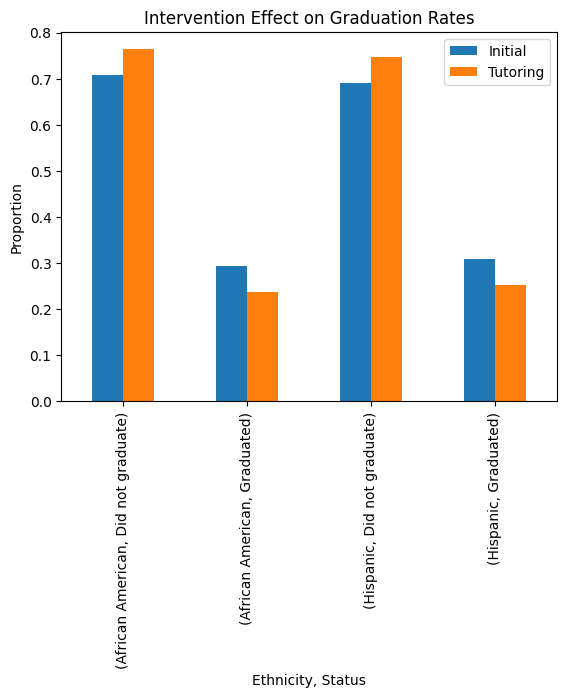

In [712]:
# Graduation rates by ethnicity
# Intervention 1 
merged_grad_rates.plot(kind='bar', stacked=False)
plt.title('Intervention Effect on Graduation Rates')
plt.xlabel('Ethnicity, Status')
plt.ylabel('Proportion')
plt.show()

In [709]:
ethn = ['Hispanic']

filtered_df = df[df['Ethnicity'].isin(ethn)]
filtered_df_mentorship = df_mentorship[df_mentorship['Ethnicity'].isin(ethn)]
filtered_df_mentorship2 = df_mentorship2[df_mentorship2['Ethnicity'].isin(ethn)]

original_coll_rates = filtered_df.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)

coll_rates = filtered_df_mentorship.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)

coll_rates2 = filtered_df_mentorship2.groupby('Ethnicity')['College_Enrollment'].value_counts(normalize=True)

merged_coll_rates = pd.concat([original_coll_rates, coll_rates, coll_rates2], axis=1)

merged_coll_rates = pd.concat([original_coll_rates, coll_rates, coll_rates2], axis=1, keys=['Initial', 'Mentorship', 'No Intervention'])

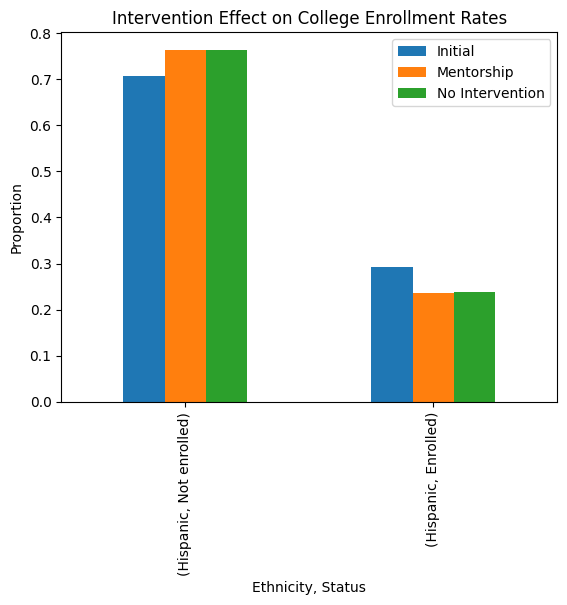

In [711]:
# College Enrollment rates for Hispanic students
# Intervention 2 
merged_coll_rates.plot(kind='bar', stacked=False)
plt.title('Intervention Effect on College Enrollment Rates')
plt.xlabel('Ethnicity, Status')
plt.ylabel('Proportion')
plt.show()

In [718]:
filtered_df = df_aid[df_aid['low_income'] == True]
filtered_df2 = df_aid2[df_aid2['low_income'] == True]

Behav_lev1 = filtered_df.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

Behav_lev2 = filtered_df2.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

merged_Behav_lev = pd.concat([Behav_lev1, Behav_lev2], axis=1)

merged_Behav_lev = pd.concat([Behav_lev1, Behav_lev2], axis=1, keys=['Financial Aid', 'No Intervention'])

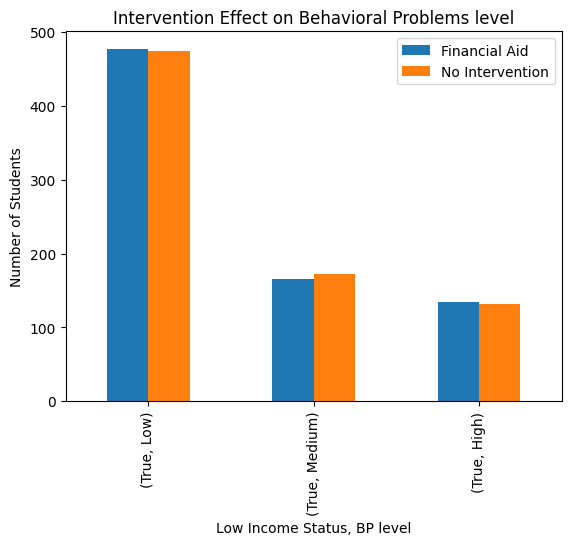

In [719]:
# Behavioral Problems level for students with low income family
# Intervention 3 
merged_Behav_lev.plot(kind='bar', stacked=False)
plt.title('Intervention Effect on Behavioral Problems level')
plt.xlabel('Low Income Status, BP level')
plt.ylabel('Number of Students')
plt.show()

## Policy Recommendations

- Not to intervene for all students. Proper intervention requires a good and comprehensive investigation on student background and unique attribiutes and needs for having a note worthy influence on his/her success. 

- Providing diverse academic support for each indivisual, specifically targeting underserved student groups like African American and Hispanic students to improve their graduation rates.

- Expanding financial assistance programs to make college more affordable for low-income students. The simulation indicates this can lower behavioral incidents.

- Developing early warning systems to identify at-risk students based on academic performance, attendance and behavior. Targeted interventions could then be provided.

- Reforming disciplinary practices that disproportionately impact underserved student groups.

- Providing training for teachers and staff on cultural awareness, implicit biases and culturally responsive teaching. This can create a more inclusive environment. 

- Investing on data collection and conducting further research to better understand gaps and causes of disparities between student groups.

- Increasing transparency around interventions, analyzing and reporting disaggregated outcomes. This allows accountability as well.

- Engaging students, families and community stakeholders from diverse backgrounds and incorporate their perspectives when designing interventions.

- Setting clear equity goals and continuously evaluate progress and success to close outcome gaps between student groups.

It has to be declare that the simulation provides valuable insights, but findings must be validated with real data before implementing policy changes.

## Sensitivity Analysis

In [791]:
df_sa1 = df.copy()
# Function to run simulation 
def run_simulation1(df, grad_cutoff):
  
  # Graduation based on test score cutoffs and college enroll
  df['grad_qualify'] = (df['Test_Scores_Math'] + df['Test_Scores_English'] > grad_cutoff)
  df.loc[df['Ethnicity'] == 'African American','grad_qualify'] = (df['Test_Scores_Math'] + df['Test_Scores_English'] > (grad_cutoff - 30)) 
  df.loc[df['Ethnicity'] == 'Hispanic','grad_qualify'] = (df['Test_Scores_Math'] + df['Test_Scores_English'] > (grad_cutoff - 15))

  df = df[df['grad_qualify'] == True]
  # Setting tutoring intervention for African American and Caucasian students
  df.loc[df['Ethnicity'] == 'African American','Intervention_Group'] = 1  
  df.loc[df['Ethnicity'] == 'Hispanic','Intervention_Group'] = 1

  # Model graduation status
  X = df[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
          'Intervention_Group', 'Extracurricular_Activities', 
          'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
          'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
          'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican', 
          'College_Enrollment_num', 'Attendance_Rate', 'Behavioral_Problems']] 

  df['Graduation_Status'] = model1.predict(X) 

  # Return modified dataframe
  return df

In [792]:
# Run with default parameters
s1_0 = run_simulation1(df_sa1, grad_cutoff=190)

# Run with default parameters
s1_1 = run_simulation1(df_sa1, grad_cutoff=180)

# Lower income cutoff
s1_2 = run_simulation1(df_sa1, grad_cutoff=170)

# Lower grad cutoff for Hispanic students
s1_3 = run_simulation1(df_sa1, grad_cutoff=160)

# Lower income cutoff
s1_4 = run_simulation1(df_sa1, grad_cutoff=150)

# Lower income cutoff
s1_5 = run_simulation1(df_sa1, grad_cutoff=140)

C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\2905203552.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Graduation_Status'] = model1.predict(X)
C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\2905203552.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Graduation_Status'] = model1.predict(X)
C:\Users\alireza dehghan\AppData\Local\Temp\ipykernel_22436\2905203552.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [793]:
ethnicities = ['African American', 'Hispanic']
df_sa1 = df_sa1[df_sa1['Ethnicity'].isin(ethnicities)]
df_sa1_grad_rates = df_sa1.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)



s1_0 = s1_0[s1_0['Ethnicity'].isin(ethnicities)]
grad_rates_0 = s1_0.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_0 = pd.concat([df_sa1_grad_rates, grad_rates_0], axis=1)
sa_grad_rates_0 = pd.concat([df_sa1_grad_rates, grad_rates_0], axis=1, keys=['Initial', 'Tutoring'])


s1_1 = s1_1[s1_1['Ethnicity'].isin(ethnicities)]
grad_rates_1 = s1_1.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_1 = pd.concat([df_sa1_grad_rates, grad_rates_1], axis=1)
sa_grad_rates_1 = pd.concat([df_sa1_grad_rates, grad_rates_1], axis=1, keys=['Initial', 'Tutoring'])



s1_2 = s1_2[s1_2['Ethnicity'].isin(ethnicities)]
grad_rates_2 = s1_2.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_2 = pd.concat([df_sa1_grad_rates, grad_rates_2], axis=1)
sa_grad_rates_2 = pd.concat([df_sa1_grad_rates, grad_rates_2], axis=1, keys=['Initial', 'Tutoring'])


s1_3 = s1_3[s1_3['Ethnicity'].isin(ethnicities)]
grad_rates_3 = s1_3.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_3 = pd.concat([df_sa1_grad_rates, grad_rates_3], axis=1)
sa_grad_rates_3 = pd.concat([df_sa1_grad_rates, grad_rates_3], axis=1, keys=['Initial', 'Tutoring'])


s1_4 = s1_4[s1_4['Ethnicity'].isin(ethnicities)]
grad_rates_4 = s1_4.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_4 = pd.concat([df_sa1_grad_rates, grad_rates_4], axis=1)
sa_grad_rates_4 = pd.concat([df_sa1_grad_rates, grad_rates_4], axis=1, keys=['Initial', 'Tutoring'])


s1_5 = s1_5[s1_5['Ethnicity'].isin(ethnicities)]
grad_rates_5 = s1_5.groupby('Ethnicity')['Graduation_Status'].value_counts(normalize=True)
sa_grad_rates_5 = pd.concat([df_sa1_grad_rates, grad_rates_5], axis=1)
sa_grad_rates_5 = pd.concat([df_sa1_grad_rates, grad_rates_5], axis=1, keys=['Initial', 'Tutoring'])

In [794]:
# Analyzing Changes in Graduation rate   
print('Sensitivity Analysis:')
print('with official cutoff score of 190:')
print(sa_grad_rates_0)
print('with official cutoff score of 180:')
print(sa_grad_rates_1)
print('with official cutoff score of 170:')
print(sa_grad_rates_2)
print('with official cutoff score of 160:')
print(sa_grad_rates_3)
print('with official cutoff score of 150:')
print(sa_grad_rates_4)
print('with official cutoff score of 140:')
print(sa_grad_rates_5)

Sensitivity Analysis:
with official cutoff score of 190:
                                     Initial  Tutoring
Ethnicity        Graduation_Status                    
African American Did not graduate   0.707269  0.732283
                 Graduated          0.292731  0.267717
Hispanic         Did not graduate   0.690669  0.625000
                 Graduated          0.309331  0.375000
with official cutoff score of 180:
                                     Initial  Tutoring
Ethnicity        Graduation_Status                    
African American Did not graduate   0.707269  0.754144
                 Graduated          0.292731  0.245856
Hispanic         Did not graduate   0.690669  0.722222
                 Graduated          0.309331  0.277778
with official cutoff score of 170:
                                     Initial  Tutoring
Ethnicity        Graduation_Status                    
African American Did not graduate   0.707269  0.764618
                 Graduated          0.292731  0.

#### The results show that by setting a cutoff score of 190 in total (overall test scores of english and math) for being qualify as graduated, and giving 15 score additional as a bonus to Hispanic students to make the initial bias in the generated dataset less effective, leads to an interesting result which was initially expected. The tutoring intervention increases the graduation rate for Hispanic students. On the other hand, by setting the cutoff score lower and lower, the results become more similar to the result conducted in previous sections.    

In [795]:
df_sa2 = df.copy()

# Function to run simulation 
def run_simulation2(df, low_income_cutoff, Int):

  # Low income based on cutoff 
  df['low_income'] = df['Parental_Income'] < low_income_cutoff
  df.loc[df['low_income'], 'Intervention_Group'] = Int

  # Model graduation status
  X = df[['Age', 'Test_Scores_Math','Test_Scores_English', 'Parental_Income',
          'Intervention_Group', 'Extracurricular_Activities', 
          'Parental_Education_num', 'Employment_Status_num', 'Gender_num',
          'Ethnicity_Other', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
          'Ethnicity_Hispanic', 'Ethnicity_AfricanAmerican',
          'Graduation_Status_num', 'Attendance_Rate', 'College_Enrollment_num']] 

  df['Behavioral_Problems_Cat'] = model3.predict(X)
  df = df[df['low_income'] == True] 

  # Return modified dataframe
  return df

In [796]:
# Lower cutoff
s2_l = run_simulation2(df_sa2, low_income_cutoff=35000, Int=1)
s2_0 = run_simulation2(df_sa2, low_income_cutoff=35000, Int=0)

# higher cutoff
s2_l_2 = run_simulation2(df_sa2, low_income_cutoff=50000, Int=1)
s2_0_2 = run_simulation2(df_sa2, low_income_cutoff=50000, Int=0)

In [797]:
Behav_lev1 = s2_l.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

Behav_lev0 = s2_0.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

BPL = pd.concat([Behav_lev1, Behav_lev0], axis=1)

BPL = pd.concat([Behav_lev1, Behav_lev0], axis=1, keys=['Financial Aid', 'No Intervention'])


Behav_lev1_2 = s2_l_2.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

Behav_lev0_2 = s2_0_2.groupby('low_income')['Behavioral_Problems_Cat'].value_counts()

BPL_2 = pd.concat([Behav_lev1_2, Behav_lev0_2], axis=1)

BPL_2 = pd.concat([Behav_lev1_2, Behav_lev0_2], axis=1, keys=['Financial Aid', 'No Intervention'])

In [798]:
# Analyzing Changes in Behavioral Problems different Level   
print('Sensitivity Analysis:')
print('with lower cutoff:')
print(BPL)
print('with higher cutoff:')
print(BPL_2)

Sensitivity Analysis:
with lower cutoff:
                                    Financial Aid  No Intervention
low_income Behavioral_Problems_Cat                                
True       Low                                197              191
           Medium                              64               69
           High                                55               56
with higher cutoff:
                                    Financial Aid  No Intervention
low_income Behavioral_Problems_Cat                                
True       Low                               1589             1573
           Medium                             521              537
           High                               355              355


#### It appears that the results maintain the other previous result and with the changes, still financial aid intervention leads to increase of number of students with low behaviroal problems. Also, it has been revealed that setting higher cutoff for determining low income families, has greater impact.